# Sequence data QC Report v1.0
## Input Parameters

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.1f}'.format(x)

configFile='qc_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id','total_beads','samples']

prm={}
for name in prmNames:
    prm[name]=parser.get('QCReport', name)

prm['samples'] =  prm['samples'].split(',')
prm['total_beads'] =  float(prm['total_beads'])
h5outfile = parser.get('QCReport', 'h5_output', fallback='qc_report.h5')
    
metrics = {}
cvg_raw = {}
cvg = {}
samples=prm['samples']
for s in samples:
    h5infile=s+'.h5'
    metrics[s]=pd.read_hdf(h5infile, key='metrics', mode='r')
    cvg_raw[s]=pd.read_hdf(h5infile, key='raw_wgs_metrics_cvg', mode='r')
    cvg[s]=pd.read_hdf(h5infile, key='wgs_metrics_cvg', mode='r')

prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
#prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,120338
total_beads,3.4e+09
samples,"[120338-BC10, 120338-BC23, 120338-BC24, 120338..."


In [2]:
def getMetric(s,file,param,t):
    m=metrics[s][(metrics[s]['File']==file) & (metrics[s]['Parameter']==param)]
    return t(m.iloc[0]['Value'])

#getMetric(samples[0],'unmapped.quality_yield_metrics','TOTAL_READS',int)

def calcTotalRow(df,c):
    a=df.sum()
    for i,b in enumerate(c):
        if not b:
            a[i]=(df.iloc[:,i]*df.iloc[:,1]).sum()/a[1]
    return a

##  Throughput

In [3]:
pd.options.display.float_format = lambda x: ('{:.2e}'.format(x) if abs(x)>1e9 else 
                                             '{:,.0f}'.format(x)) if abs(x)>1e0 else '{:,.2%}'.format(x)

tp=pd.DataFrame()
for s in samples:
    bcReads=getMetric(s,'unmapped.quality_yield_metrics','TOTAL_READS',float)
    filtReads=getMetric(s,'unmapped.quality_yield_metrics','PF_READS',float)
    alignedReads=getMetric(s,'alignment_summary_metrics','PF_READS_ALIGNED',float)
    hqalignedReads=getMetric(s,'alignment_summary_metrics','PF_HQ_ALIGNED_READS',float)
    pfBases=getMetric(s,'unmapped.quality_yield_metrics','PF_BASES',float)
    bq20Bases=getMetric(s,'unmapped.quality_yield_metrics','Q20_BASES',float)
    bq30Bases=getMetric(s,'unmapped.quality_yield_metrics','Q30_BASES',float)
    bq20mapq20Bases=getMetric(s,'alignment_summary_metrics','PF_HQ_ALIGNED_Q20_BASES',float)
    dupRate=getMetric(s,'wgs_metrics','PCT_EXC_DUPE',float)
    readLen=getMetric(s,'alignment_summary_metrics','MEAN_READ_LENGTH',float)
    
    row=pd.DataFrame({'All reads':0,
                      'BC reads':bcReads,
                      '%BC reads':bcReads/prm['total_beads'],
                      'PF reads':filtReads,
                      '%PF reads':filtReads/bcReads,
                      'Aligned reads':alignedReads,
                      'HQ aligned reads':hqalignedReads,
                      '% aligned reads':alignedReads/filtReads,
                      '% HQ aligned reads':hqalignedReads/filtReads,
                      '% BQ20 bases':bq20Bases/pfBases,
                      '% BQ30 bases':bq30Bases/pfBases,
                      '% duplication':dupRate,
                      'Non-dup HQ reads':hqalignedReads*(1-dupRate),
                      'Read length':readLen,
                      '% Non-dup HQ bases':bq20mapq20Bases/pfBases*(1-dupRate),
                      '# Non-dup HQ bases':bq20mapq20Bases*(1-dupRate),
                     },index=[s])
    tp=pd.concat([tp,row])
tp.loc['Total'] = calcTotalRow(tp,[1,1,1,1,0,1,1,0,0,0,0,0,1,0,0])

allBcReads=tp.loc['Total','BC reads']
tp.loc['Total','All reads']=prm['total_beads'] if prm['total_beads']>allBcReads else allBcReads


tp[['BC reads','%BC reads','PF reads','%PF reads','Aligned reads','% aligned reads','% HQ aligned reads',
    '% BQ20 bases','% BQ30 bases','% duplication','Read length','% Non-dup HQ bases','# Non-dup HQ bases']].transpose()

,120338-BC10,120338-BC23,120338-BC24,120338-BC39,Total
BC reads,"759,993,492","691,411,591","667,895,872","649,177,148",2.77e+09
%BC reads,22.25%,20.25%,19.56%,19.01%,81.07%
PF reads,"759,993,492","691,411,591","667,895,872","649,177,148",2.77e+09
%PF reads,100.00%,100.00%,100.00%,100.00%,100.00%
Aligned reads,"759,951,419","691,355,982","667,841,912","649,113,445",2.77e+09
% aligned reads,99.99%,99.99%,99.99%,99.99%,99.99%
% HQ aligned reads,91.91%,90.80%,91.22%,90.64%,91.17%
% BQ20 bases,92.90%,89.32%,89.39%,89.10%,90.27%
% BQ30 bases,87.28%,84.50%,84.49%,84.13%,85.17%
% duplication,28.95%,22.28%,21.36%,21.50%,23.71%


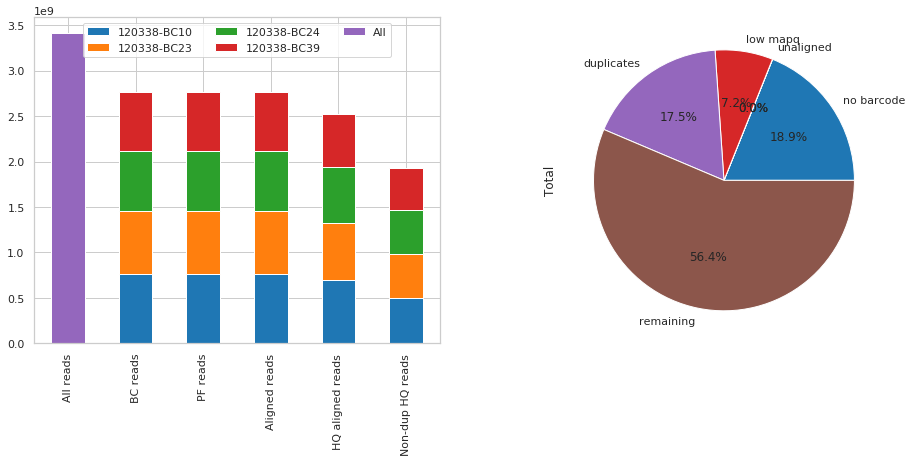

In [12]:
import seaborn as sns
sns.set_context("notebook")
sns.set_style("whitegrid")

tp_plot=tp.loc[samples,['All reads','BC reads','PF reads','Aligned reads','HQ aligned reads','Non-dup HQ reads']].transpose()
tp_plot['All']=[tp['All reads']['Total']]+[0]*(len(tp_plot.index)-1)

cat=['All reads','BC reads','PF reads','Aligned reads','HQ aligned reads','Non-dup HQ reads']
new_cat=['no barcode', 'filtered','unaligned','low mapq','duplicates','remaining']
reads=tp.loc[['Total'],cat]
reads['None']=[0]
diff_reads=reads.transpose().diff(-1).loc[cat,:]
diff_reads['Category']=new_cat
diff_reads.set_index('Category',inplace=True)

fig, ax = plt.subplots(1,2,figsize=(16,6))
ax1=tp_plot.plot.bar(stacked=True, ax=ax[0]).legend(loc='upper center', ncol=3)
ax2=diff_reads.plot.pie(y='Total', ax=ax[1], autopct='%.1f%%',legend=False)

##  Coverage

In [5]:
pd.options.display.float_format = lambda x: '{:,.1f}'.format(x) if x>1 else '{:,.1%}'.format(x)

#pd.options.display.float_format = '{:,.2f}'.format
cm=pd.DataFrame()
maxMed=30
for s in samples:
    cvg_raw[s]['Cumu']=cvg_raw[s]['Count'].cumsum()/sum(cvg_raw[s]['Count'])

    meanCvg=getMetric(s,'wgs_metrics','MEAN_COVERAGE',float)
    meanRawCvg=getMetric(s,'raw_wgs_metrics','MEAN_COVERAGE',float)
    medianCvg=getMetric(s,'wgs_metrics','MEDIAN_COVERAGE',float)
    medianRawCvg=getMetric(s,'raw_wgs_metrics','MEDIAN_COVERAGE',float)
    pct10x=getMetric(s,'wgs_metrics','PCT_10X',float)
    pct20x=getMetric(s,'wgs_metrics','PCT_20X',float)
    pct0x=cvg[s]['Count'][0]/sum(cvg[s]['Count'])
    f80=medianRawCvg/cvg_raw[s][cvg_raw[s]['Cumu']>0.20].index[0]
    f90=medianRawCvg/cvg_raw[s][cvg_raw[s]['Cumu']>0.10].index[0]
    f95=medianRawCvg/cvg_raw[s][cvg_raw[s]['Cumu']>0.05].index[0]
    
    
    maxMed=max(maxMed,medianCvg)
    
    row=pd.DataFrame({'Mean HQ coverage':meanCvg,
                      'Median HQ coverage':medianCvg,
                      'Mean raw coverage':meanRawCvg,
                      'Median raw coverage':medianRawCvg,
                      '% genome =0X':pct0x,
                      '% genome >10X':pct10x,
                      '% genome >20X':pct20x,
                      'F80 (raw)':f80,
                      'F90 (raw)':f90,
                      'F95 (raw)':f95,
                      },index=[s])
    cm=pd.concat([cm,row])
cm.loc['Total'] = calcTotalRow(cm,[1,1,1,1,0,0,0,0,0,0])
cm.transpose()

,120338-BC10,120338-BC23,120338-BC24,120338-BC39,Total
Mean HQ coverage,37.6,30.2,29.1,28.6,125.4
Median HQ coverage,39.0,32.0,30.0,30.0,131.0
Mean raw coverage,40.1,33.5,32.3,31.8,137.7
Median raw coverage,40.0,34.0,32.0,32.0,138.0
% genome =0X,3.9%,3.8%,3.8%,3.9%,3.8%
% genome >10X,94.6%,94.3%,94.1%,94.0%,94.2%
% genome >20X,92.6%,88.9%,87.4%,87.0%,89.2%
F80 (raw),1.2,1.3,1.2,1.3,1.2
F90 (raw),1.3,1.5,1.5,1.5,1.4
F95 (raw),1.6,1.8,1.8,1.8,1.7


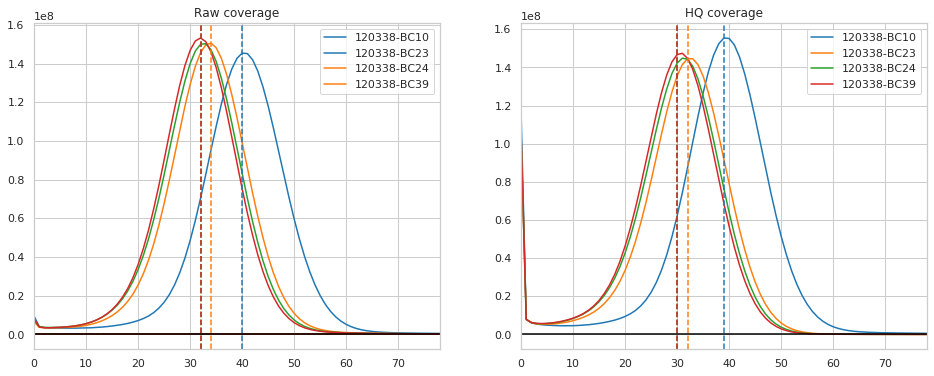

In [6]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
titles='Raw coverage','HQ coverage'
wmet=['raw_wgs_metrics','wgs_metrics']
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,cvgHist in enumerate([cvg_raw,cvg]):
    for j,s in enumerate(samples):
        cvgHist[s].plot(ax=ax[i],color=cols[j])      
    ax[i].legend(samples)

for i,cvgHist in enumerate([cvg_raw,cvg]):
    for j,s in enumerate(samples):
        ax[i].axvline(getMetric(s,wmet[i],'MEDIAN_COVERAGE',float),color=cols[j],ls='--')
    ax[i].set_xlim([0,maxMed*2])
    ax[i].set_title(titles[i])
    ax[i].axhline(0,color='k')

    

##  Error

In [7]:
pd.options.display.float_format = lambda x: '{:,.1f}'.format(x) if x>1 else '{:,.2%}'.format(x)

em=pd.DataFrame()
for s in samples:
    mismatchError=getMetric(s,'alignment_summary_metrics','PF_MISMATCH_RATE',float)
    indelError=getMetric(s,'alignment_summary_metrics','PF_INDEL_RATE',float)
    
    row=pd.DataFrame({'Mean HQ coverage':mismatchError,
                      'Median HQ coverage':indelError,
                      },index=[s])
    em=pd.concat([em,row])
em.loc['Total'] = em.mean()
em.transpose()

,120338-BC10,120338-BC23,120338-BC24,120338-BC39,Total
Mean HQ coverage,0.37%,0.37%,0.38%,0.39%,0.38%
Median HQ coverage,0.40%,0.26%,0.27%,0.27%,0.30%


## Appendix

In [8]:
metrics[samples[0]]['File'].unique()

array(['alignment_summary', 'alignment_summary_metrics',
       'duplicate_metrics', 'gc_bias.detail_metrics',
       'gc_bias.summary_metrics', 'quality_yield_metrics',
       'raw_wgs_metrics', 'unmapped.quality_yield_metrics', 'wgs_metrics'],
      dtype=object)

In [9]:
metrics[samples[0]][metrics[samples[0]]['File']=='alignment_summary_metrics']

,File,Class,Parameter,Value
24,alignment_summary_metrics,AlignmentSummaryMetrics,CATEGORY,UNPAIRED
25,alignment_summary_metrics,AlignmentSummaryMetrics,TOTAL_READS,759993492
26,alignment_summary_metrics,AlignmentSummaryMetrics,PF_READS,759993492
27,alignment_summary_metrics,AlignmentSummaryMetrics,PCT_PF_READS,1
28,alignment_summary_metrics,AlignmentSummaryMetrics,PF_NOISE_READS,0
29,alignment_summary_metrics,AlignmentSummaryMetrics,PF_READS_ALIGNED,759951419
30,alignment_summary_metrics,AlignmentSummaryMetrics,PCT_PF_READS_ALIGNED,0.999945
31,alignment_summary_metrics,AlignmentSummaryMetrics,PF_ALIGNED_BASES,163264161198
32,alignment_summary_metrics,AlignmentSummaryMetrics,PF_HQ_ALIGNED_READS,698527861
33,alignment_summary_metrics,AlignmentSummaryMetrics,PF_HQ_ALIGNED_BASES,150946704538


In [10]:
metrics[samples[0]][metrics[samples[0]]['File']=='unmapped.quality_yield_metrics']

,File,Class,Parameter,Value
119,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,TOTAL_READS,759993492
120,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,PF_READS,759993492
121,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,READ_LENGTH,220
122,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,TOTAL_BASES,167606602500
123,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,PF_BASES,167606602500
124,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,Q20_BASES,155702403274
125,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,PF_Q20_BASES,155702403274
126,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,Q30_BASES,146284032933
127,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,PF_Q30_BASES,146284032933
128,unmapped.quality_yield_metrics,CollectQualityYieldMetrics$QualityYieldMetrics,Q20_EQUIVALENT_YIELD,308328343259


In [11]:
metrics[samples[0]][metrics[samples[0]]['File']=='wgs_metrics']

,File,Class,Parameter,Value
130,wgs_metrics,WgsMetrics,GENOME_TERRITORY,3043453562
131,wgs_metrics,WgsMetrics,MEAN_COVERAGE,37.562023
132,wgs_metrics,WgsMetrics,SD_COVERAGE,14.092131
133,wgs_metrics,WgsMetrics,MEDIAN_COVERAGE,39
134,wgs_metrics,WgsMetrics,MAD_COVERAGE,5
135,wgs_metrics,WgsMetrics,PCT_EXC_ADAPTER,0
136,wgs_metrics,WgsMetrics,PCT_EXC_MAPQ,0
137,wgs_metrics,WgsMetrics,PCT_EXC_DUPE,0.289495
138,wgs_metrics,WgsMetrics,PCT_EXC_UNPAIRED,0
139,wgs_metrics,WgsMetrics,PCT_EXC_BASEQ,0.013467
